## Imports

In [6]:
import h5py
import time
import datetime as dt

import matplotlib.pyplot as plt

from matplotlib import animation, rc, image, colors
from matplotlib.animation import FFMpegWriter

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter
sns.set_style("ticks")

# %load_ext line_profiler

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Helper Functions

In [2]:
from enum import Enum

class Status(Enum):
    """ An enum that represents the infection status of the Agents.
    """
    SUSCEPTIBLE = 1
    INFECTED = 2
    RECOVERED = 3
    QUARANTINED = 4
    
stat_c = {
    "SUSCEPTIBLE": "#ffffff",
    "INFECTED": "#ff0000",
    "RECOVERED": "#00ff00",
    "QUARANTINED": "#ffa500"
}

def reshape(data, status=None):
    """Reshape data for convenient plotting.
    """
    if data.shape[1] == 3:
        data = data[data[:,2] == status][:,:2]
    elif data.shape == (0,):
        return data.reshape(2, -1)
    return data.T[::-1]

def str_date(timestamp):
    date = dt.datetime.fromtimestamp(timestamp)
    return date.strftime('%y-%m-%d %H:%M:%S')

class FasterFFMpegWriter(FFMpegWriter):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.frame_format = 'argb'

    def grab_frame(self, **savefig_kwargs):
        try:
            self.fig.set_size_inches(self._w, self._h)
            self.fig.set_dpi(self.dpi)
            self.fig.canvas.draw()
            self._frame_sink().write(self.fig.canvas.tostring_argb()) 
        except (RuntimeError, IOError) as e:
            out, err = self._proc.communicate()
            raise IOError('Error saving animation to file (cause: {0}) '
                      'Stdout: {1} StdError: {2}. It may help to re-run '
                      'with --verbose-debug.'.format(e, out, err)) 

## Animation Functions

In [3]:
def draw_frame(i, cmap='bwr_r', label=False):
    fig, ax = plt.subplots(figsize=[10, 10])
    ax.imshow(img)
    im = ax.imshow(virus[i] != 0, alpha=virus[i] / 2**14, cmap=cmap)
    tx = ax.text(1, 2, str_date(timesteps[i]), c='w', fontsize=14)

    plot_ref = []
    for status in Status:
        ref = ax.plot(
            *reshape(agents[i], status.value), 'o', ms=16,
            c=stat_c[status.name], mec="black", label=status.name)
        plot_ref.append(ref[0])
        
    if label:
        for n in range(agents[i].shape[0]):
            x, y, _ = agents[i][n]
            ax.annotate(n+1, (y, x), va='center', ha='center')
    
    return im, tx, plot_ref

# animation function. This is called sequentially
def animate(i):
    im.set_data(virus[i] != 0)
    im.set_alpha(virus[i] / 2**14)
    tx.set_text(str_date(timesteps[i]))
    for status, ref in zip(Status, plot_ref):
        ref.set_data(*reshape(agents[i], status.value))
    return (im,) + tuple(plot_ref)

## Loading Simulation Results Data

In [4]:
%%time

mapfile = 'mapfiles/eng301.png'
img = image.imread(mapfile)

results = 'output/simulation.hdf5'
with h5py.File(results, 'r') as file:
    agents = file['agents'].__array__()
    virus = file['virus'].__array__()
    timesteps = file['timesteps'].__array__()
    
print(agents.shape)
print(virus.shape)
print(timesteps.shape)

(4111, 8, 3)
(4111, 94, 106)
(4111,)
CPU times: user 616 ms, sys: 186 ms, total: 802 ms
Wall time: 982 ms


## Generating Simulation Animation

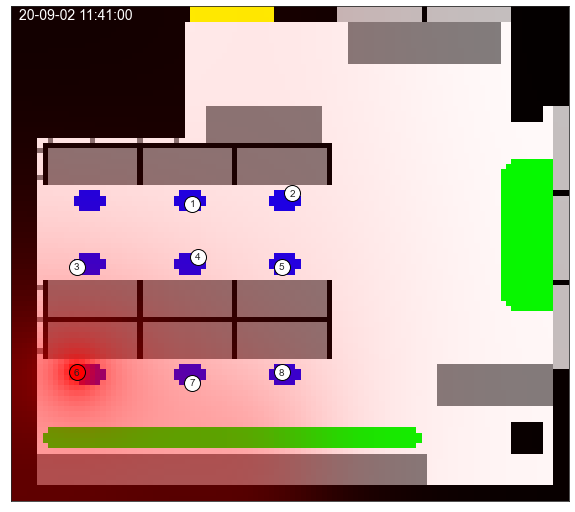

In [7]:
im, tx, plot_ref = draw_frame(1000, label=True)
ax = plt.gca()
_ = ax.set(xticks=[], yticks=[])
plt.savefig('simulation_frame_eng301.pdf', dpi=300, bbox_inches='tight')

In [ ]:
%%time
# call the animator. blit=True means only re-draw the parts that have changed.
rc('animation', html='jshtml')
rc('animation', embed_limit=100.0)
im, tx, plot_ref, labels = draw_frame(0)
anim = animation.FuncAnimation(plt.gcf(), animate, frames=timesteps.size, interval=50, blit=True)

HTML(anim.to_jshtml())

## Saving Animation as video

In [20]:
%%time
writer = FasterFFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim.save('scenario.mp4', writer=writer)

CPU times: user 3min 23s, sys: 5.98 s, total: 3min 29s
Wall time: 3min 35s


## Plotting Results

In [57]:
%%time
n = 13
res = []
for i in range(n):
    results = f'outputs/simulation_{i}.hdf5'
    with h5py.File(results, 'r') as file:
        agents = file['agents'].__array__()
        act_stat = agents[:,:,2]
        # padded = np.pad(act_stat, ((0, 2500-act_stat.shape[0]), (0, 0)), constant_values=-1)
        
        res.append(act_stat)
res = np.array(res)
prob = (res != 1).sum(axis=0) / n

CPU times: user 21.5 ms, sys: 5.2 ms, total: 26.7 ms
Wall time: 40.3 ms


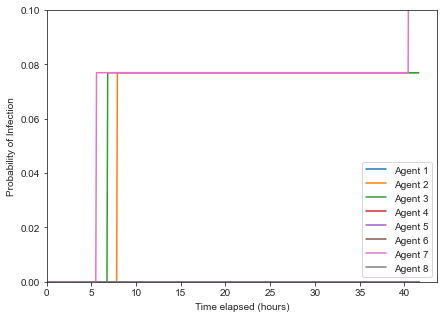

In [58]:
t_step = 5
save_resolution = 60
hour = np.arange(prob.shape[0]) / (3600 / t_step / save_resolution)

fig, ax = plt.subplots(figsize=[7, 5])

for i in range(prob.shape[-1]):
    _ = ax.plot(hour, prob[:,i], label=f'Agent {i+1}')
_ = ax.set(
    xlabel='Time elapsed (hours)',
    ylabel='Probability of Infection',
    xlim=[0, None],
    ylim=[0, 0.1]
)
_ = ax.legend()
plt.savefig('infection_probability_eng301.pdf', dpi=300, bbox_inches='tight')

### **Set this to look nicer or not have filled areas for the stackplot

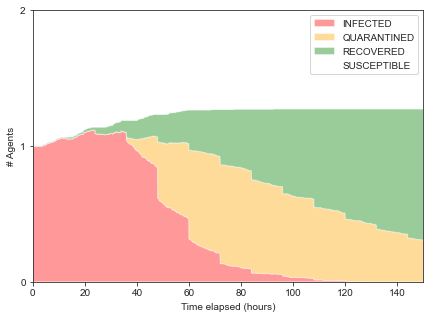

In [254]:
# stats = [list((agents[:,:,2] == status.value).sum(axis=1)) for status in Status]
stats = [[(x == status.value).sum(axis=1) for status in Status] for x in res]
stats = np.array(stats).mean(axis=0)
labels = [status.name for status in Status]

order = [1, 3, 2, 0]
stats = np.array(stats)[order]
labels = np.array(labels)[order]

fig, ax = plt.subplots(figsize=[7, 5])

_ = ax.stackplot(np.arange(pad) / 12, stats, labels=labels, colors=['r', 'orange', 'g', 'w'], alpha=0.4)
_ = ax.set(
    xlim=[0, 150],
    ylim=[0, 2],
    xlabel='Time elapsed (hours)',
    ylabel='# Agents',
    yticks=[0, 1, 2]
)
_ = ax.legend()
plt.savefig('simulation_recovery_eng301.pdf', dpi=300, bbox_inches='tight')

## Pulling from distributions for recovery

array([3.47, 4.01, 4.72])

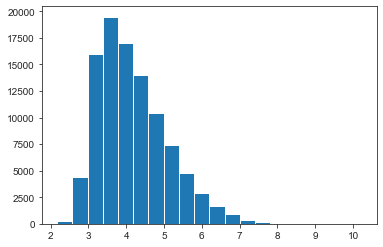

In [197]:
from scipy.stats import skewnorm
dist = skewnorm.rvs(6, loc=3, scale=1.5, size=100000)    

_ = plt.hist(dist, bins=20)
np.percentile(dist, [25, 50, 75]).round(2)